# DDQN

In [1]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count
from time import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import pandas as pd

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
torch.cuda.is_available()

True

In [3]:
device_name = "cpu"

if True:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cuda


In [4]:
UPDATE_TARGET_STEPS = 500
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-6

In [5]:
import sys
sys.path.append(r"C:\Users\takat\PycharmProjects\machine-learning")
import flowdata
import flowenv

In [14]:
# from flowdata.src.flow_data import using_data

raw_data_train, raw_data_test = flowdata.flow_data.using_data()

train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)

In [15]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [16]:
class DQN(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [17]:
def select_action(state):
    global n_actions, policy_net, steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # print(f"action: {policy_net(state).max(1).indices.view(1, 1)}")
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

def optimize_model():
    global policy_net, target_net, optimizer, memory

    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_actions = policy_net(non_final_next_states).max(1).indices.unsqueeze(1)
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_actions).squeeze(1)

    expected_state_action_values = reward_batch + GAMMA * next_state_values

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

def get_h_m_s(seconds: float):
    hours = int(seconds // 3600)
    minutes = int((seconds - hours * 3600) // 60)
    seconds = seconds - hours * 3600 - minutes * 60
    return hours, minutes, seconds

def loading_bar(episode, total_episodes, interval):
    pro_size_float = (episode + 1) / total_episodes * 20
    show = pro_size_float * 5
    pro_size = int(pro_size_float)

    # episode...interval -> total_episodes...interval * total_episodes / episode
    last_time = interval * (total_episodes - episode) / (episode + 1)
    hours, minutes, seconds = get_h_m_s(last_time)
    print(f"\r[{'#' * pro_size}{' ' * (20 - pro_size)}] {show:3.02f}%, last={hours:02d}:{minutes:02d}:{seconds:03.3f}", end="")

In [18]:
episode_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

def plot_metrics(show_result=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(episode_metrics["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(episode_metrics["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(episode_metrics["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(episode_metrics["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(episode_metrics["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calcurate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr


<Figure size 640x480 with 0 Axes>

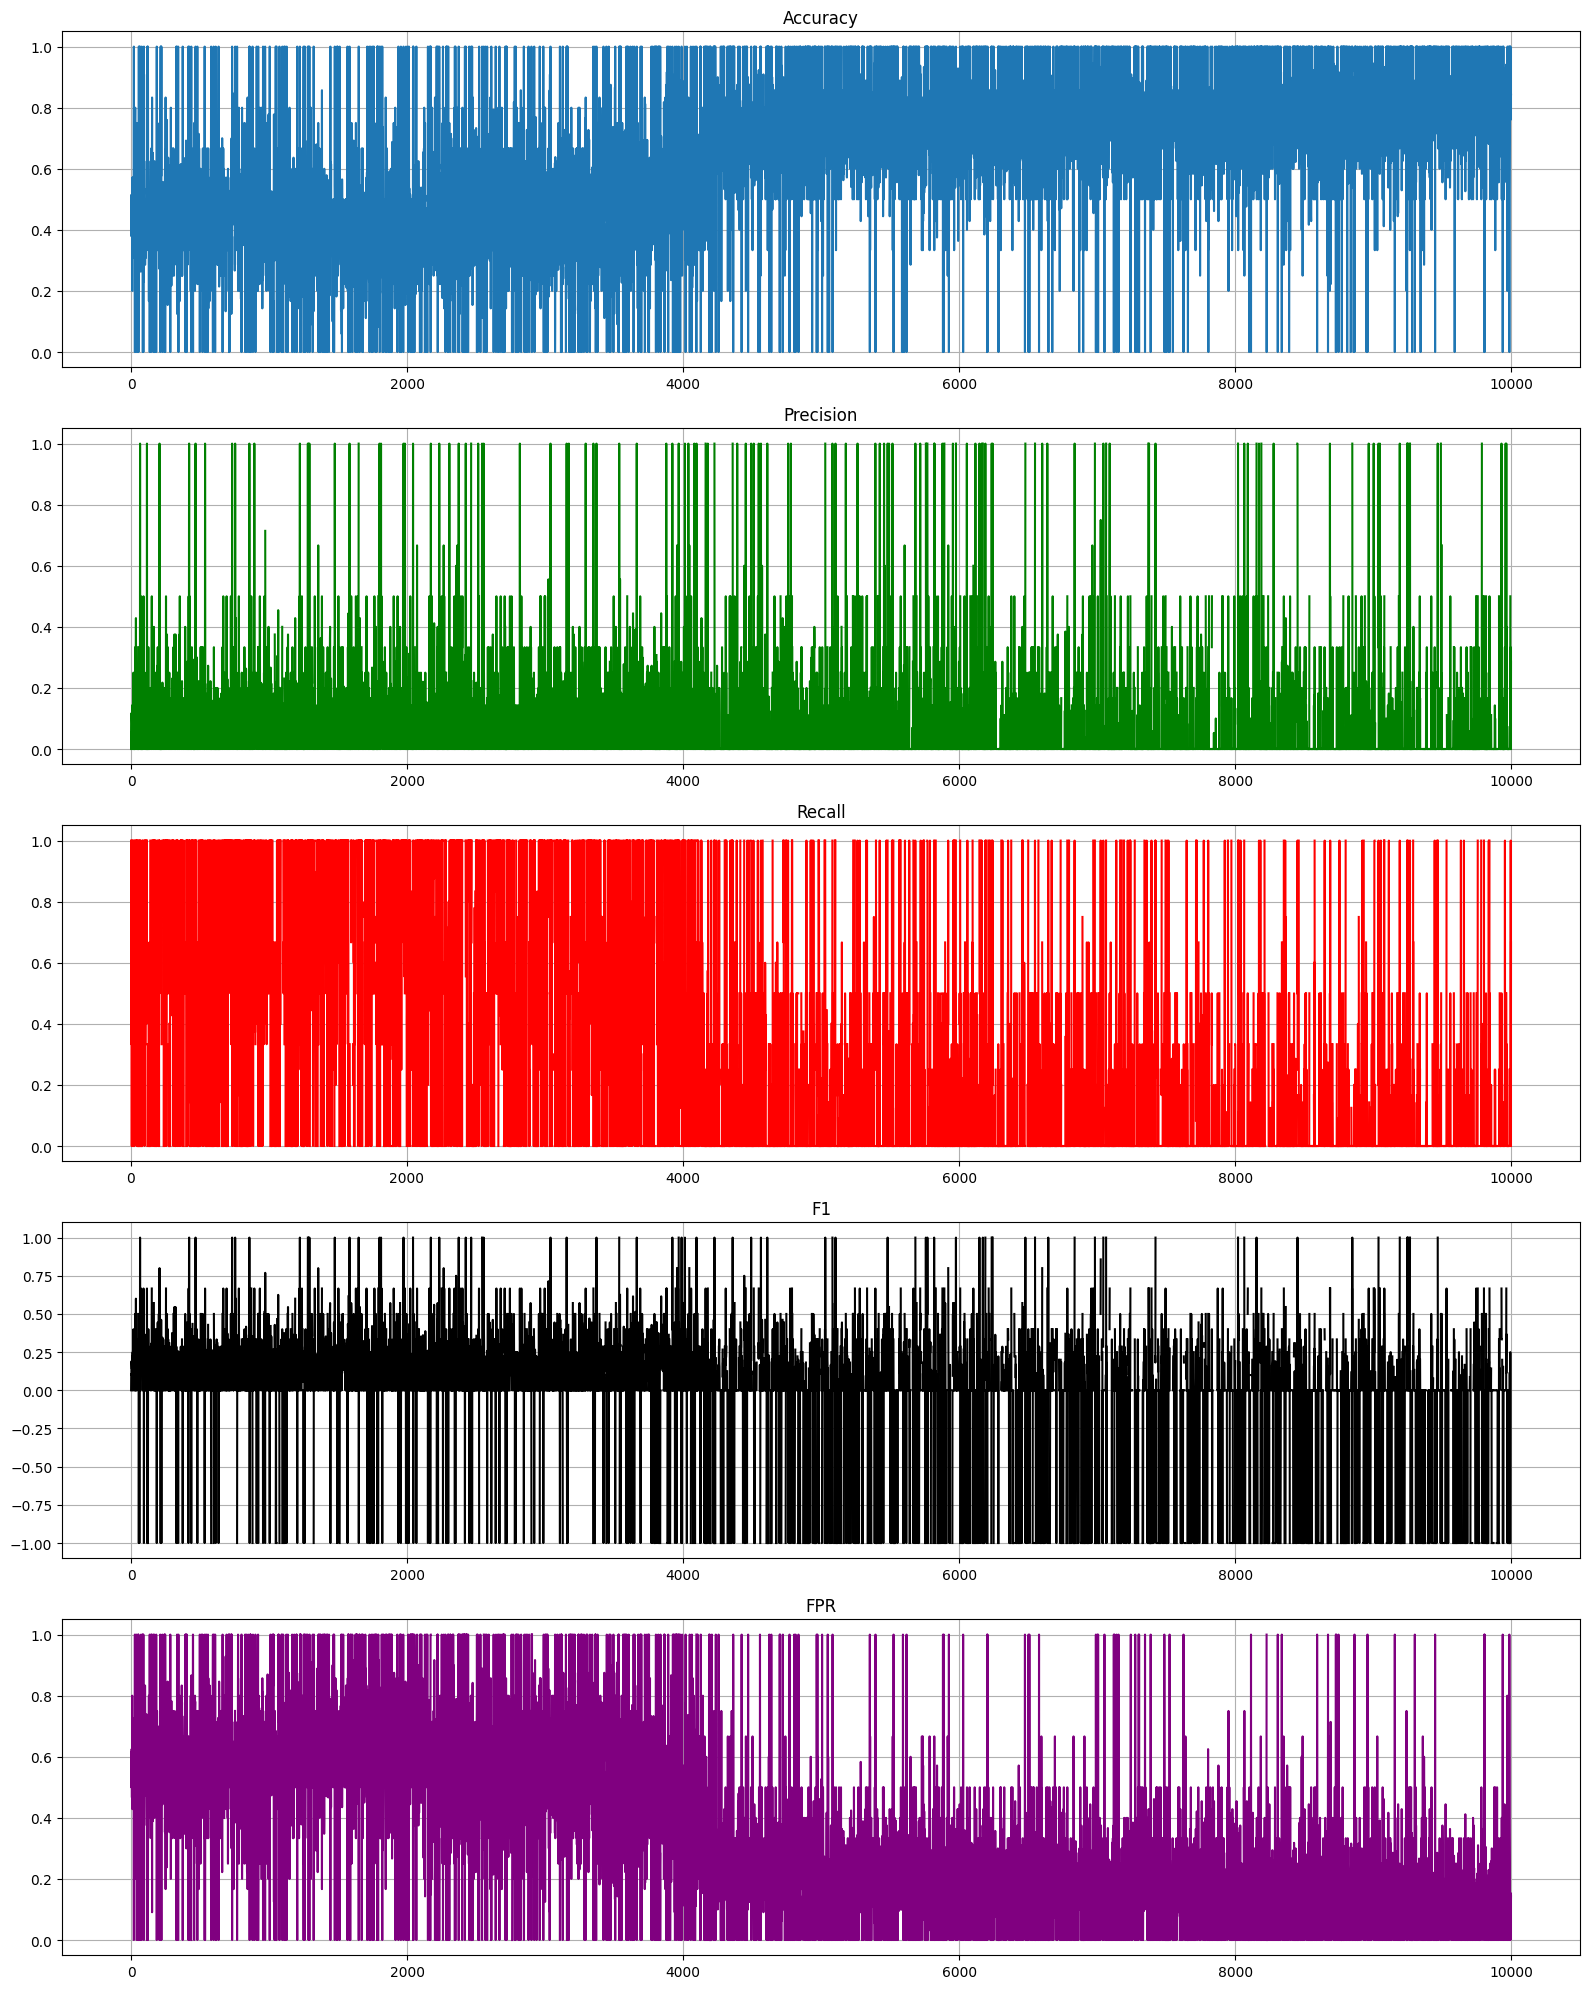

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
n_actions = train_env.action_space.n
n_inputs = train_env.observation_space.shape[0]

state, info = train_env.reset()

policy_net = DQN(n_inputs, n_actions).to(device)
if False:
    policy_net.load_state_dict(torch.load("ddqn.pth", map_location=device, weights_only=True))
target_net = DQN(n_inputs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(int(1e6))

num_episodes = 10000
steps_done = 0
episode_rewards = []
mean_rewards = []


x = []

start_time = time()
for i_episode in range(num_episodes):
    state, info = train_env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    confusions = [0, 0, 0, 0]
    sum_reward = 0
    true_count = 0
    for t in count():
        action = select_action(state)
        true_count += 1 if action.item() == 1 else 0
        next_state, reward, terminated, truncated, info = train_env.step(action.item())

        reward = torch.tensor([reward], device=device)
        done = bool(terminated)
        confusions[info["value"]] += 1

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state
        sum_reward += reward.item()

        optimize_model()

        if steps_done % UPDATE_TARGET_STEPS == 0:
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in target_net_state_dict:
                target_net_state_dict[key] = TAU * policy_net_state_dict[key] + (1 - TAU) * target_net_state_dict[key]
            target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(sum_reward)
            mean_rewards.append(np.mean(episode_rewards))
            break
    x.append(i_episode)
    end_time = time()


    # if i_episode > 0 and i_episode % 100 == 0:
    #     print(f" Episode {i_episode}, reward: {sum_reward}")
    #
    # loading_bar(i_episode, num_episodes, end_time - start_time)
    # print(f"count: {true_count}", end="")
    ac, pr, re, f1, fpr = calcurate_metrics(*confusions)
    episode_metrics["accuracy"].append(ac)
    episode_metrics["precision"].append(pr)
    episode_metrics["recall"].append(re)
    episode_metrics["f1"].append(f1)
    episode_metrics["fpr"].append(fpr)

    plot_metrics()

# plt.plot(episode_rewards)
# plt.plot(mean_rewards, color="red")
plot_metrics(show_result=True)
plt.show()

result = pd.DataFrame(episode_rewards, columns=["reward"])
torch.save(policy_net.state_dict(), "ddqn.pth")
train_env.close()

C:\Users\takat\PycharmProjects\machine-learning\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\takat\PycharmProjects\machine-learning\.venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


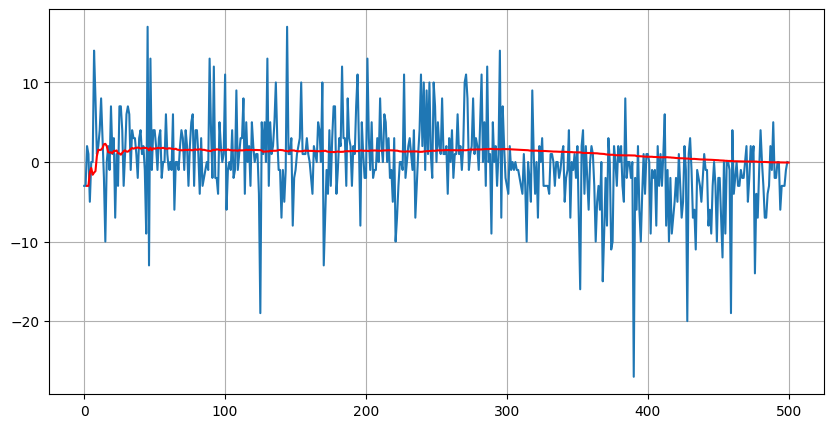

In [13]:
mean_rewards = []

for i in range(0, len(episode_rewards)):
    # print(f"Episode {i}, mean reward: {np.mean(episode_rewards[0:i])}")
    if not episode_rewards[0:i]:
        mean_rewards.append(0)
    mean_rewards.append(np.mean(episode_rewards[0:i]))

plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.plot(mean_rewards, color="red")
plt.grid()
plt.show()

In [15]:
trained_net = DQN(n_inputs, n_actions).to(device)
trained_net.load_state_dict(torch.load("ddqn.pth", weights_only=True))
trained_net.eval()

state_raw, _ = test_env.reset()
state = torch.tensor(state_raw, dtype=torch.float32, device=device).unsqueeze(0)
# max_len = len(raw_data_test) - 1
max_len = len(raw_data_test) - 1


confusion_matrix = [0, 0, 0, 0] # TP, FP, TN, FN
total_reward = 0

start_time = time()
for i in range(max_len):
    with torch.no_grad():
        action = trained_net(state).max(1).indices.view(1, 1)
    # print(f"action: {action}")

    next_state, reward, terminated, _, info = test_env.step(action.item())
    # print(f"info: {info}")

    reward = torch.tensor([reward], device=device)
    total_reward += reward.item()

    next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

    confusion_index = (0 if "P" in info["confusion"] else 1) if "T" in info["confusion"] else (2 if "P" in info["confusion"] else 3)
    confusion_matrix[confusion_index] += 1

    state = next_state
    end_time = time()
    # loading_bar(i, max_len, end_time - start_time)

print()
test_env.close()

print(f"confusion matrix: {confusion_matrix}")

tp = confusion_matrix[0]
tn = confusion_matrix[1]
fp = confusion_matrix[2]
fn = confusion_matrix[3]

accuracy = (tp + tn) / (tp + fp + fn + tn)
print(f"Accuracy : {accuracy:.5}")
precision = tp / (tp + fp)
print(f"Precision: {precision:.5}")
recall = tp / (tp + fn) if tp + fn != 0 else 0.0
print(f" Recall  : {recall:.5}")
f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0.0
print(f"    F1   : {f1:.5}")
fpr = fp / (fp + tn) if fp + tn != 0 else 0.0
print(f"    FPR  : {fpr:.5}")

metrics = [accuracy, precision, recall, f1, fpr]
metrics = [n * 100 for n in metrics]
metrics_labels = ["Accuracy", "Precision", "Recall", "F1", "FPR"]

plt.figure(1)
plt.bar(metrics_labels, metrics)
plt.grid()


0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:True => reward: -1, confusion: FN
0:True => reward: -1, confusion: FN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confus

ZeroDivisionError: division by zero